In [1]:
# Smart Resume Screener — Jupyter Notebook (Python script with cell markers)
# Save this file as `notebook.py` or open it in Jupyter/VS Code as a notebook (cells are separated by `# %%`).
# Instructions:
# 1) Create a virtualenv and install requirements listed below (or run pip commands in the first cell).
# 2) Place sample resumes in `sample_resumes/` or update the paths below.
# 3) Run cells top to bottom.


# %%
# CELL 0 — Installation (run in terminal, not inside notebook if kernel lacks permissions)
# !pip install --upgrade pip
# !pip install streamlit spacy scikit-learn pdfplumber python-docx pandas rapidfuzz matplotlib joblib
# !python -m spacy download en_core_web_sm


# %%

In [2]:
!pip install pdfplumber

In [3]:
!pip install streamlit spacy scikit-learn pdfplumber python-docx pandas rapidfuzz matplotlib joblib

In [4]:
# CELL 1 — Imports
import os
from pathlib import Path
import re
import json
from collections import defaultdict


import pdfplumber
import docx


import spacy
from spacy.matcher import PhraseMatcher


from rapidfuzz import fuzz, process


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import matplotlib.pyplot as plt


# Set working directory variables
ROOT = Path('.').resolve()
SAMPLE_DIR = ROOT / 'sample_resumes'
SKILLS_FILE = ROOT / 'skills_list.txt'
RESULTS_DIR = ROOT / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

In [5]:
## CELL 2 - Utility: ensure sample folders and default skills file exist

# Define the list unconditionally
default_skills = [
    'python','java','c++','machine learning','deep learning','nlp','natural language processing',
    'pandas','numpy','scikit-learn','tensorflow','keras','sql','aws','docker','kubernetes',
    'react','node.js','excel','project management','rest api','git','linux','spaCy','pytorch'
]

if not SAMPLE_DIR.exists():
    SAMPLE_DIR.mkdir()
    print(f'Created sample folder: {SAMPLE_DIR} -- add PDFs/DOCX to test')

# Create a default skills.list text file if not present
if not SKILLS_FILE.exists():
    with open(SKILLS_FILE, 'w', encoding='utf-8') as f:
        f.write('\n'.join(default_skills))
    print(f'Created default skills file at {SKILLS_FILE}')


# Load skills list
with open(SKILLS_FILE, 'r', encoding='utf-8') as f:
    SKILLS = [line.strip() for line in f if line.strip()]
print(f'Loaded {len(SKILLS)} skills')

Loaded 24 skills


In [6]:
# CELL 3 — Text extraction from PDF/DOCX


def extract_text_from_pdf(path):
    text = []
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text.append(page_text)
    return '\n'.join(text)

def extract_text_from_docx(path):
    doc = docx.Document(path)
    paragraphs = [p.text for p in doc.paragraphs]
    return '\n'.join(paragraphs)

def extract_text(path):
    path = str(path)
    if path.lower().endswith('.pdf'):
        return extract_text_from_pdf(path)
    elif path.lower().endswith('.docx') or path.lower().endswith('.doc'):
        return extract_text_from_docx(path)
    else:
# fallback: read raw text
        try:
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                return f.read()
        except Exception as e:
            print('Failed to read file:', e)
            return ''

# %%

In [7]:
# CELL 4 — Heuristic: extract years of experience


def extract_years_of_experience(text):
    text_lower = text.lower()
    m = re.search(r'(\d+(?:\.\d+)?)\s*\+?\s*(years|yrs)\b', text_lower)
    if m:
        try:
            return float(m.group(1))
        except:
            pass
# fallback: find four-digit years and compute span
    years_all = [int(y) for y in re.findall(r'\b(19|20)\d{2}\b', text)]
    if years_all:
        try:
            # re.findall returned two-digit prefix groups due to grouping; instead find four-digit years properly
            years4 = [int(y) for y in re.findall(r'\b(19|20)\d{2}\b', text)]
            # If previous fails, use alternative: find 20xx or 19xx as raw matches
            # but keep simple: return None if ambiguous
            return None
        except:
            return None
    return None

In [8]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 6.7 MB/s eta 0:00:02
     ------- -------------------------------- 2.4/12.8 MB 6.4 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 6.4 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 6.2 MB/s eta 0:00:02
     ------------------ --------------------- 6.0/12.8 MB 6.0 MB/s eta 0:00:02
     ---------------------- ----------------- 7.3/12.8 MB 6.2 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 6.2 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 6.2 MB/s eta 0:00:01
     --------------------------------- ------ 10.7/12.8 MB 5.9 MB/s eta 0:00:01
     ------------------------------------- -- 12.1/12.8 MB 5.9 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 5.8 MB/s eta 0:00:00
[+] Download and installation successful
You can now loa

In [9]:
# CELL 5 — NLP: load spaCy and build matcher
print('Loading spaCy model (en_core_web_sm) — this may take a few seconds...')
nlp = spacy.load('en_core_web_sm', disable=['parser'])




def build_skill_phrase_matcher(skills_list, attr='LOWER'):
    matcher = PhraseMatcher(nlp.vocab, attr=attr)
    patterns = [nlp.make_doc(s) for s in skills_list]
    matcher.add('SKILLS', patterns)
    return matcher


matcher = build_skill_phrase_matcher(SKILLS)
print('PhraseMatcher built')

Loading spaCy model (en_core_web_sm) — this may take a few seconds...
PhraseMatcher built


In [10]:
# CELL 6 — Skill extraction function (PhraseMatcher + fuzzy fallback)


def extract_skills_with_matcher(text, matcher, skills_list, fuzzy_threshold=90):
    doc = nlp(text)
    matches = matcher(doc)
    found = set()
    for match_id, start, end in matches:
        span = doc[start:end].text.strip()
        found.add(span.lower())
# Map to canonical skills if available
    skills_map = {s.lower(): s for s in skills_list}
    canonical_found = set()
    for s in found:
        canonical_found.add(skills_map.get(s, s))


# Fuzzy fallback on short candidate phrases: split text into lines and check
    fuzzy_matches = set()
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    # limit lines to reasonable number
    sample_lines = lines[:200]
    for line in sample_lines:
        choices = process.extract(line, skills_list, scorer=fuzz.partial_ratio, limit=5)
        for choice, score, _ in choices:
            if score >= fuzzy_threshold:
                fuzzy_matches.add(choice)
    # Merge
    all_skills = set([s for s in canonical_found]) | fuzzy_matches
    return all_skills

In [11]:
# CELL 7 — Scoring (TF-IDF similarity + skill coverage)


def jd_resume_similarity_score(jd_text, resume_text):
    vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
    X = vect.fit_transform([jd_text, resume_text])
    sim = cosine_similarity(X[0:1], X[1:2])[0][0]
    return float(sim)




def skill_coverage_score(required_skills, resume_skills):
    required_set = set([s.lower() for s in required_skills])
    resume_set = set([s.lower() for s in resume_skills])
    if not required_set:
        return 0.0
    matched = len(required_set & resume_set)
    return matched / len(required_set)




def combined_match_score(jd_text, resume_text, required_skills, resume_skills, weights=(0.6, 0.4)):
    sim = jd_resume_similarity_score(jd_text, resume_text)
    scov = skill_coverage_score(required_skills, resume_skills)
    score = weights[0]*sim + weights[1]*scov
    return score, sim, scov

In [17]:
# CELL 8 — Demo: pick a sample resume (you can change the path) and a sample job description
# Find sample resumes in folder
samples = list(SAMPLE_DIR.glob('*'))
if not samples:
    print('No sample resumes found in sample_resumes/. Add some PDFs or DOCX files to test.')
else:
    print('Found sample files:', [s.name for s in samples])


# Example JD (you can replace it)
JD_TEXT = (
    "We are hiring a Python developer with experience in natural language processing (NLP), spaCy, pandas, "
    "and REST API development. Familiarity with Docker and AWS is a plus. Strong communication skills required."
)


# If a sample exists, test with the first one
if samples:
    sample_path = samples[0]
    print('Using sample:', sample_path.name)
    resume_text = extract_text(sample_path)
    # optional: save raw
    with open(RESULTS_DIR / f'{sample_path.stem}_raw.txt', 'w', encoding='utf-8') as f:
        f.write(resume_text)


    resume_skills = extract_skills_with_matcher(resume_text, matcher, SKILLS)
    jd_required = extract_skills_with_matcher(JD_TEXT, matcher, SKILLS)


    score, jd_sim, scov = combined_match_score(JD_TEXT, resume_text, jd_required, resume_skills, weights=(0.6, 0.4))

    # convert to percentage scale (0..100) for display and CSV
    score_pct = score * 100.0
    jd_sim_pct = jd_sim * 100.0
    scov_pct = scov * 100.0


    print('\n=== Screening Summary ===')
    print('Resume file:', sample_path.name)
    print(f'Match score: {score_pct:.2f} / 100')
    print(f'JD similarity: {jd_sim_pct:.2f}% | Skill coverage: {scov_pct:.2f}%')
    print('Matched skills (resume):', sorted(list(resume_skills)))
    print('Required skills (JD):', sorted(list(jd_required)))
    missing = sorted([s for s in jd_required if s.lower() not in {x.lower() for x in resume_skills}])
    print('Missing skills:', missing)


# Save results to CSV
    df = pd.DataFrame([{
        'resume_filename': sample_path.name,
        'match_score_pct': round(score_pct, 2),
        'jd_similarity_pct': round(jd_sim_pct, 2),
        'skill_coverage_pct': round(scov_pct, 2),
        'matched_skills': ';'.join(resume_skills),
        'required_skills': ';'.join(jd_required),
        'missing_skills': ';'.join(missing)
    }])
    csv_path = RESULTS_DIR / f'{sample_path.stem}_screen.csv'
    df.to_csv(csv_path, index=False)
    print('Saved CSV to', csv_path)

Found sample files: ['GarvitRastogi_Resume.pdf', 'resume other.pdf', 'resumeother.pdf']
Using sample: GarvitRastogi_Resume.pdf

=== Screening Summary ===
Resume file: GarvitRastogi_Resume.pdf
Match score: 17.25 / 100
JD similarity: 3.75% | Skill coverage: 37.50%
Matched skills (resume): ['communication', 'excel', 'git', 'java', 'machine learning', 'numpy', 'pandas', 'project management', 'python', 'scikit-learn', 'sql', 'tensorflow']
Required skills (JD): ['aws', 'communication', 'docker', 'natural language processing', 'nlp', 'pandas', 'python', 'rest api']
Missing skills: ['aws', 'docker', 'natural language processing', 'nlp', 'rest api']
Saved CSV to C:\Users\codep\smart-resume-screener\results\GarvitRastogi_Resume_screen.csv


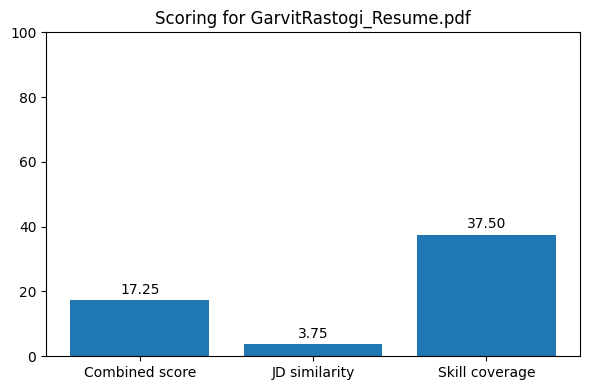

In [19]:
# CELL 9 — Visualization: bar chart of components


def plot_scores(score, jd_sim, scov, title=None):
    """Plot scores on a 0..100 percentage scale."""
    labels = ['Combined score', 'JD similarity', 'Skill coverage']
    values = [score, jd_sim, scov]
    plt.figure(figsize=(6,4))
    plt.bar(labels, values)
    plt.ylim(0,100)
    plt.title(title or 'Resume Screening Scores')
    for i,v in enumerate(values):
        plt.text(i, v + 2, f'{v:.2f}', ha='center')
    plt.tight_layout()
    plt.show()

# If we computed values above, plot them (use percent values)
if samples:
# convert to percent for plotting
    score_pct = score * 100.0
    jd_sim_pct = jd_sim * 100.0
    scov_pct = scov * 100.0
    plot_scores(score_pct, jd_sim_pct, scov_pct, title=f'Scoring for {sample_path.name}')
# %%

In [20]:
# CELL 10 — Bulk screening: run on all files in sample_resumes/
def bulk_screen(jd_text, input_dir=SAMPLE_DIR, out_csv=RESULTS_DIR / 'bulk_results.csv'):
    rows = []
    files = list(input_dir.glob('*'))
    for f in files:
        if not f.suffix.lower() in ['.pdf', '.docx', '.txt']:
            continue
        text = extract_text(f)
        r_skills = extract_skills_with_matcher(text, matcher, SKILLS)
        jd_required = extract_skills_with_matcher(jd_text, matcher, SKILLS)
        score, jd_sim, scov = combined_match_score(jd_text, text, jd_required, r_skills, weights=(0.6,0.4))
        # convert to percentage scale (0..100)
        score_pct = score * 100.0
        jd_sim_pct = jd_sim * 100.0
        scov_pct = scov * 100.0
        missing = sorted([s for s in jd_required if s.lower() not in {x.lower() for x in r_skills}])
        rows.append({
            'filename': f.name,
            'score_pct': round(score_pct, 2),
            'jd_similarity_pct': round(jd_sim_pct, 2),
            'skill_coverage_pct': round(scov_pct, 2),
            'matched_skills': ';'.join(r_skills),
            'required_skills': ';'.join(jd_required),
            'missing_skills': ';'.join(missing)
        })
    df = pd.DataFrame(rows)
    df.sort_values('score_pct', ascending=False, inplace=True)
    df.to_csv(out_csv, index=False)
    return df


# Example: run bulk if samples exist
if samples:
    df_bulk = bulk_screen(JD_TEXT)
    print('Bulk results saved to', RESULTS_DIR / 'bulk_results.csv')
    display_df = df_bulk.head(20)
    print(display_df)


    print('Bulk results saved to', RESULTS_DIR / 'bulk_results.csv')
    display_df = df_bulk.head(20)
    print(display_df)

Bulk results saved to C:\Users\codep\smart-resume-screener\results\bulk_results.csv
                   filename  score_pct  jd_similarity_pct  skill_coverage_pct  \
1          resume other.pdf      33.69               6.15                75.0   
2           resumeother.pdf      27.83               4.72                62.5   
0  GarvitRastogi_Resume.pdf      17.25               3.75                37.5   

                                      matched_skills  \
1  nlp;keras;docker;pandas;excel;scikit-learn;sql...   
2  keras;rest api;java;sql;tensorflow;aws;node.js...   
0  project management;java;pandas;scikit-learn;sq...   

                                     required_skills  \
1  aws;docker;rest api;pandas;natural language pr...   
2  aws;docker;rest api;pandas;natural language pr...   
0  aws;docker;rest api;pandas;natural language pr...   

                                      missing_skills  
1                                       aws;rest api  
2   communication;docker;natura

In [15]:
# CELL 11 — Save notebook outputs and final notes
print('\nNotebook finished. Check the results/ folder for CSV and raw text outputs.')
print('Tips:')
print('- Improve skills list in skills_list.txt with synonyms & variants (e.g., "rest api" vs "restful api").')
print('- For better semantic matching consider SentenceTransformers (embeddings).')
print('- For production, add PII/privacy controls and secure storage.')


Notebook finished. Check the results/ folder for CSV and raw text outputs.
Tips:
- Improve skills list in skills_list.txt with synonyms & variants (e.g., "rest api" vs "restful api").
- For better semantic matching consider SentenceTransformers (embeddings).
- For production, add PII/privacy controls and secure storage.
